In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd
from math import pi

from tqdm import tqdm 

def Index2date(X,Y0,YF,M0=1,D0=1,MF=12,DF=31):
    """
    X is days since D0/M0/Y0 where D0 is in [0 to 30] M0 is in [0 to 11] and Y0 is the year
    YF MF DF is the final date in the data set
    """
    #list of years considered
    years = range(Y0,YF+1)
    #list of days in each month for a normal year
    Day_list_reg = [31,28,31,30,31,30,31,31,30,31,30,31]
    Day_list_leap = [31,29,31,30,31,30,31,31,30,31,30,31]
    #list of the indicies of the first of each month
    day1ofmonthreg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    day1ofmonthleap = [0,31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    #list of text strings for each month
    Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    #for when I actually implement different start days other than january 1st
    #mindex=M0
    #yindex=Y0
    #dindex=D0
    mindex=0
    date = [] #len(date) ==3 [year,month,day]
    #figure out which year X is in and if it is a leap year
    for yy in years:
        if yy%4 == 0:
            daysinyear = 366
            isleap = True
        else:
            daysinyear = 365
            isleap = False
        if X < daysinyear:
            date.append(yy)
            break
        else:
            X -= daysinyear
        #print('X is '+str(X))
    if isleap:
        day1ofmonth = day1ofmonthleap
    else:
        day1ofmonth = day1ofmonthreg
    for mm in range(mindex,12):
        if X >= day1ofmonth[mm]:
            mindex = mm
            date.append(mm)
        else:
            break
    day = X-day1ofmonth[mindex]+1
    date.append(day)
    if  day < 10:
        DateString = Months[mindex]+' '+'0'+str(int(day))+', '+str(yy)
    else:
        DateString = Months[mindex]+' '+str(int(day))+', '+str(yy)
    return DateString,date

def YMD2index(y,m,d,y1=2000,m1=1,d1=1):
    
    #list of days in each month for a normal year
    Day_list_reg = [31,28,31,30,31,30,31,31,30,31,30,31]
    Day_list_leap = [31,29,31,30,31,30,31,31,30,31,30,31]
    #list of the indicies of the first of each month
    day1ofmonthreg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
    day1ofmonthleap = [0,31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    #list of text strings for each month
    Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    ind=0
    for year in range(y1,y+1):
        if year != y:
            if year%4==0:
                ind += 366
            else:
                ind += 365
        elif year%4==0:
            Day_list=Day_list_leap
            day1ofmonth = day1ofmonthleap
        else:
            Day_list=Day_list_reg
            day1ofmonth = day1ofmonthreg
    ind += day1ofmonth[m-1]
    ind += (d-1)
    return ind

In [2]:
fpath = '/home/swenson/era5_data_direct_1.0degree_Version2/'
Wdat = xr.open_dataset(fpath+"Omegas_TVQ_parallel_3x3x3_2000-2010_Regions-1through7_95percentile.nc")
Pdat = xr.open_dataset(fpath+"tp/ERA5_2000-2010_percentiles.nc")

In [3]:
times = Wdat['times'].values
lats = Wdat['lats'].values
lons = Wdat['lons'].values
wft = np.zeros(Pdat['tp'].values.shape)
wft.fill(np.nan)
wfv = np.zeros(Pdat['tp'].values.shape)
wfv.fill(np.nan)
wfq = np.zeros(Pdat['tp'].values.shape)
wfq.fill(np.nan)
# wfa_v = np.zeros(Pdat['tp'].values.shape)
# wfa_v.fill(np.nan)
# wfa_t = np.zeros(Pdat['tp'].values.shape)
# wfa_t.fill(np.nan)
for elm in tqdm(range(Wdat['Omega_T'].shape[0])):
    wft[times[elm],lats[elm],lons[elm]] = Wdat['Omega_T'].values[elm]
    wfv[times[elm],lats[elm],lons[elm]] = Wdat['Omega_V'].values[elm]
    wfq[times[elm],lats[elm],lons[elm]] = Wdat['Omega_Q'].values[elm]
#     wfa_v[times[elm],lats[elm],lons[elm]] = Wdat['Omega_av'].values[elm]
#     wfa_t[times[elm],lats[elm],lons[elm]] = Wdat['Omega_at'].values[elm]

100%|██████████| 3065211/3065211 [05:03<00:00, 10088.07it/s]


In [4]:
EventsPerDay = np.sum(np.sum(~np.isnan(wft),axis=1),axis=1)

In [18]:
#Finds the indicies of the nth most extreme days
n=20
ind = np.argpartition(EventsPerDay, -n)[-n:]
print(ind)
print(EventsPerDay[ind])
#Finds the indicie of the most extreme day
# MaxExtreme = np.where(EventsPerDay == np.max(EventsPerDay))[0][0]
# print(MaxExtreme)

[20347 87522 59551 20346 87515 86154 87514 87513 86155 36600 59555 59554
 59553 59552 86156 59550 59549 87512 87121 86153]
[145 145 145 146 147 151 150 146 151 149 148 152 151 152 148 153 147 148
 148 148]


In [19]:
days2study = [59550,87514,36600,86153,20347]

In [6]:
Cats = np.zeros(np.shape(wft))
Cats.fill(np.nan)
for elm in tqdm(range(len(times))):
        V = wfv[times[elm],lats[elm],lons[elm]]
        T = wft[times[elm],lats[elm],lons[elm]]
        Q = wfq[times[elm],lats[elm],lons[elm]]
    #     av = region
        if V>0 and T>0 and Q>0:
            Cats[times[elm],lats[elm],lons[elm]] = 0
        elif V<0 and T>0 and Q>0:
            Cats[times[elm],lats[elm],lons[elm]] = 1
        elif V<0 and T<0 and Q>0:
            Cats[times[elm],lats[elm],lons[elm]] = 2
        elif V>0 and T<0 and Q>0:
            Cats[times[elm],lats[elm],lons[elm]] = 3
        elif V>0 and T<0 and Q<0:
            Cats[times[elm],lats[elm],lons[elm]] = 4
        elif V>0 and T>0 and Q<0:
            Cats[times[elm],lats[elm],lons[elm]] = 5
        elif V<0 and T>0 and Q<0:
            Cats[times[elm],lats[elm],lons[elm]] = 6
        elif V<0 and T<0 and Q<0:
            Cats[times[elm],lats[elm],lons[elm]] = 7

100%|██████████| 3065211/3065211 [00:17<00:00, 179678.26it/s]


In [22]:
tstring[0][:3]+'-'+tstring[0][4:6]+'-'+tstring[0][8:12]+'-'+str(int(hour))+"hrs"

'Oct-29-2009-17hrs'

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5]


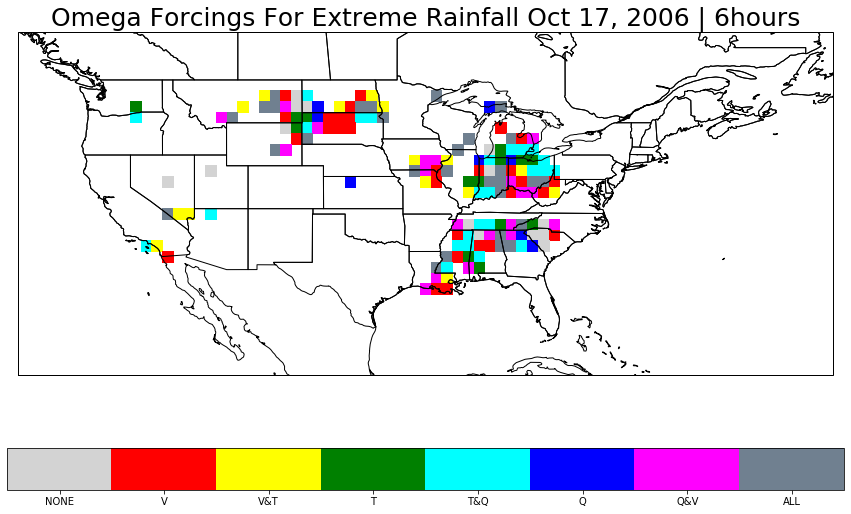

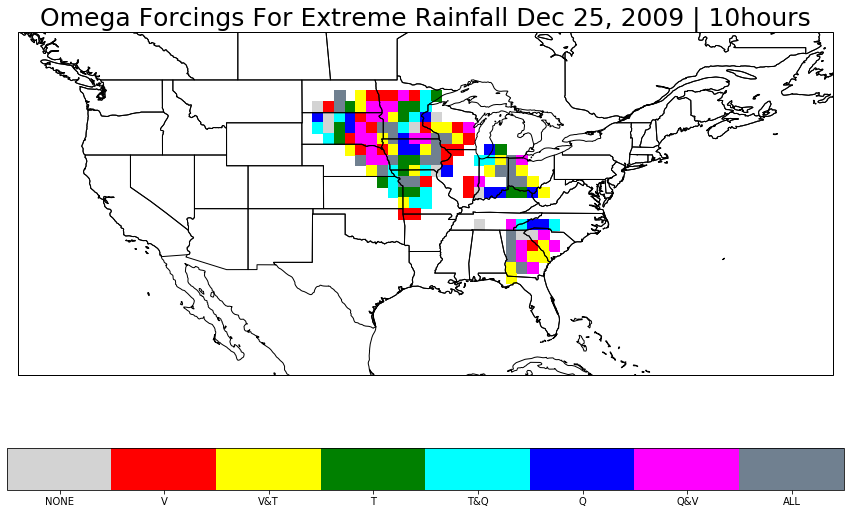

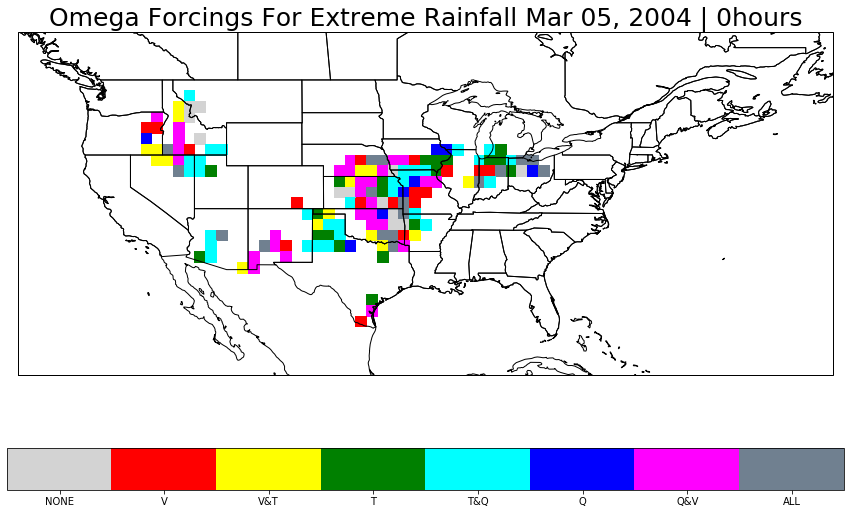

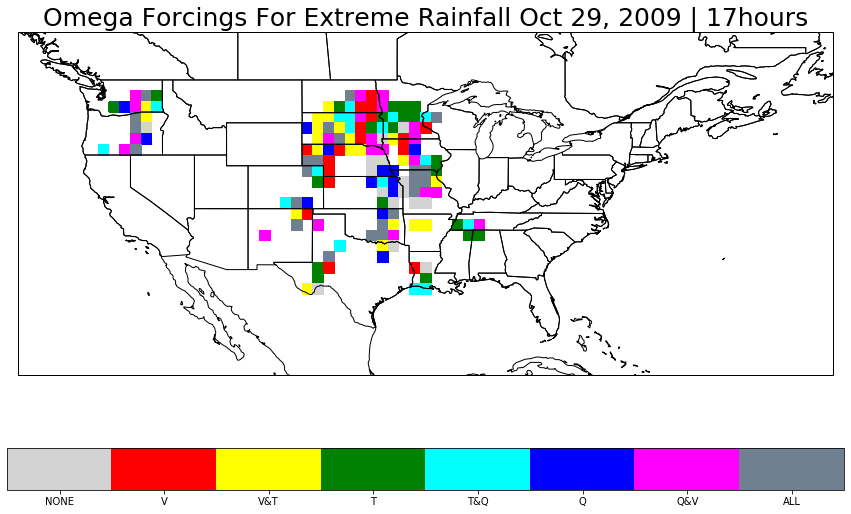

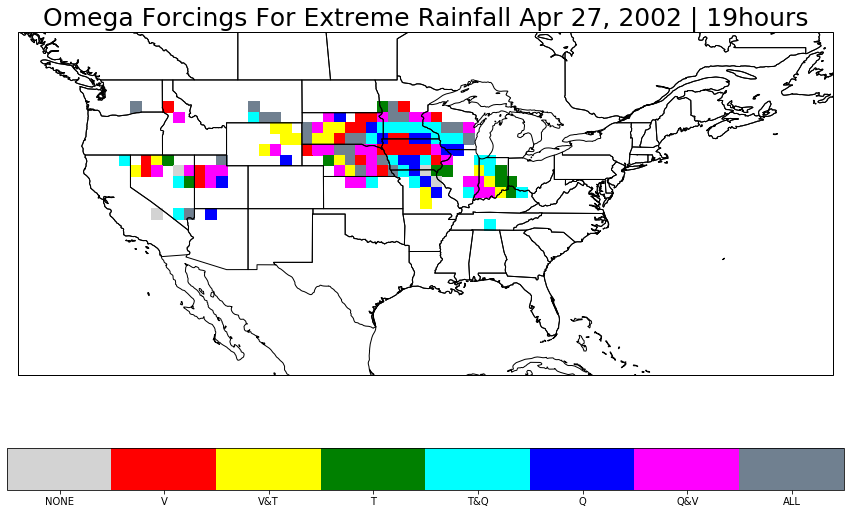

In [24]:
# Let's also design our color mapping: 1s should be plotted in red, 2s in orange, etc...
col_dict={0:"lightgrey",
          1:"red",
          2:"yellow",
          3:"green",
          4:"cyan",
          5:"blue",
          6:"magenta",
          7:"slategrey"}
# create a colormar from our list of colors
cm = mpl.colors.ListedColormap([col_dict[x] for x in col_dict.keys()])
# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["NONE","V","V&T","T","T&Q","Q","Q&V","ALL"])
len_lab = len(labels)
# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = mpl.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

#plotting set up
proj = ccrs.PlateCarree()
titlesize = 25
for elm in days2study:
    day = np.floor(elm/24)
    hour = elm - day*24
    tstring = Index2date(day,2000,2010,M0=1,D0=1,MF=12,DF=31)
    



    title = "Omega Forcings For Extreme Rainfall " + tstring[0] + ' | ' + str(int(hour))+"hours"
    MyFigure = plt.figure(figsize=(15,9))

    ax = MyFigure.add_subplot(1, 1, 1, projection=proj)
    plt.title(title,fontsize = titlesize)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    cs = ax.pcolormesh(Pdat['longitude'].values,Pdat['latitude'].values,Cats[elm,:,:],cmap=cm,norm=norm)
    #set up the ticks to be in the middle of the discrete color blocks on the colorbar
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = plt.colorbar(cs, format=fmt, ticks=tickz,orientation='horizontal')
#     ax.contour(Pdat['longitude'].values,Pdat['latitude'].values,Pdat['tp'][MaxExtreme,:,:].values,levels=[0.01,0.02,0.025,0.03,0.035,0.04],linewidths=1)
    plt.savefig("/home/swenson/projects/AGU2020/plots/IndividualEvents/"+tstring[0][:3]+'-'+tstring[0][4:6]+'-'+tstring[0][8:12]+'-'+str(int(hour))+"hrs.png")

In [10]:
Pdat

<xarray.Dataset>
Dimensions:      (latitude: 30, longitude: 70, percent: 101, time: 96432)
Coordinates:
  * longitude    (longitude) float32 -127.0 -126.0 -125.0 ... -60.0 -59.0 -58.0
  * latitude     (latitude) float32 52.0 51.0 50.0 49.0 ... 26.0 25.0 24.0 23.0
  * time         (time) datetime64[ns] 2000-01-01 ... 2010-12-31T23:00:00
  * percent      (percent) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
Data variables:
    tp           (time, latitude, longitude) float32 0.0017607734 ... 3.1936914e-05
    percentiles  (percent, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-13 01:51:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...